In [1]:
!pip install ensemble_boxes


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO

In [157]:
# ensemble csv files mm faster mm det2 det2
submission_files = ['']
submission_df = [pd.read_csv(file) for file in submission_files]

In [158]:
image_ids = submission_df[0]['image_id'].tolist()

In [159]:
# ensemble 할 file의 image 정보를 불러오기 위한 json
annotation = '/opt/ml/dataset/test.json'
coco = COCO(annotation)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# NMS

In [160]:
prediction_strings = []
file_names = []
# ensemble 시 설정할 iou threshold 이 부분을 바꿔가며 대회 metric에 알맞게 적용해봐요!
iou_thr = 0.55 # default 0.4

# 각 image id 별로 submission file에서 box좌표 추출
for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
#     각 submission file 별로 prediction box좌표 불러오기
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            
            if float(box[0]) < 0:
                box[0] = 0
            if float(box[1]) < 0:
                box[1] = 0
            if float(box[2]) > image_info['width']:
                box[2] = image_info['width']
            if float(box[3]) > image_info['height']:
                box[3] = image_info['height']
                
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
#     예측 box가 있다면 이를 ensemble 수행
    if len(boxes_list):
        boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(label) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

In [161]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('final_add_nms.csv',index=False)

submission.head()

,PredictionString,image_id
0,0 0.5218454003334045 318.36896 676.42834 346.0...,test/0000.jpg
1,0 0.584729 638.34485 650.7262 689.488 845.7962...,test/0001.jpg
2,0 0.9944688 879.63385 466.0863 1022.936 631.10...,test/0002.jpg
3,0 0.48509258 3.3125305 6.858429 1016.34686 975...,test/0003.jpg
4,0 0.9659395 465.9897 409.05228 658.0527 538.02...,test/0004.jpg


# WBF

In [155]:
from ensemble_boxes import weighted_boxes_fusion

prediction_strings = []
file_names = []
iou_thr = 0.55
skip_box_thr = 0.0001 # Skip-box threshold for WBF

# 각 image id 별로 submission file에서 box좌표 추출
for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    
    # 각 submission file 별로 prediction box좌표 불러오기
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            
            if float(box[0]) < 0:
                box[0] = 0
            if float(box[1]) < 0:
                box[1] = 0
            if float(box[2]) > image_info['width']:
                box[2] = image_info['width']
            if float(box[3]) > image_info['height']:
                box[3] = image_info['height']
                
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    # 예측 box가 있다면 이를 ensemble 수행
    if len(boxes_list):
        # 앙상블 방식 변경(WBF)
        boxes, scores, labels = weighted_boxes_fusion(
            boxes_list, scores_list, labels_list, iou_thr=iou_thr, skip_box_thr=skip_box_thr
        )
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

# submission 파일 작성
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('final_wbf.csv', index=False)

In [156]:
submission = pd.read_csv('final_wbf.csv', index=False))
submission.head()

,PredictionString,image_id
0,7 0.9187645316123962 600.4840698242188 519.456...,test/0000.jpg
1,5 0.8292531371116638 130.66656494140625 0.1899...,test/0001.jpg
2,1 0.7133646607398987 771.4761962890625 406.894...,test/0002.jpg
3,9 0.8428995013237 155.79835510253906 259.77069...,test/0003.jpg
4,1 0.7804774045944214 195.6656036376953 251.315...,test/0004.jpg


# 시각화

(933135, [239185, 177794, 34224, 55697, 39639, 124688, 55173, 160153, 12880, 33702])


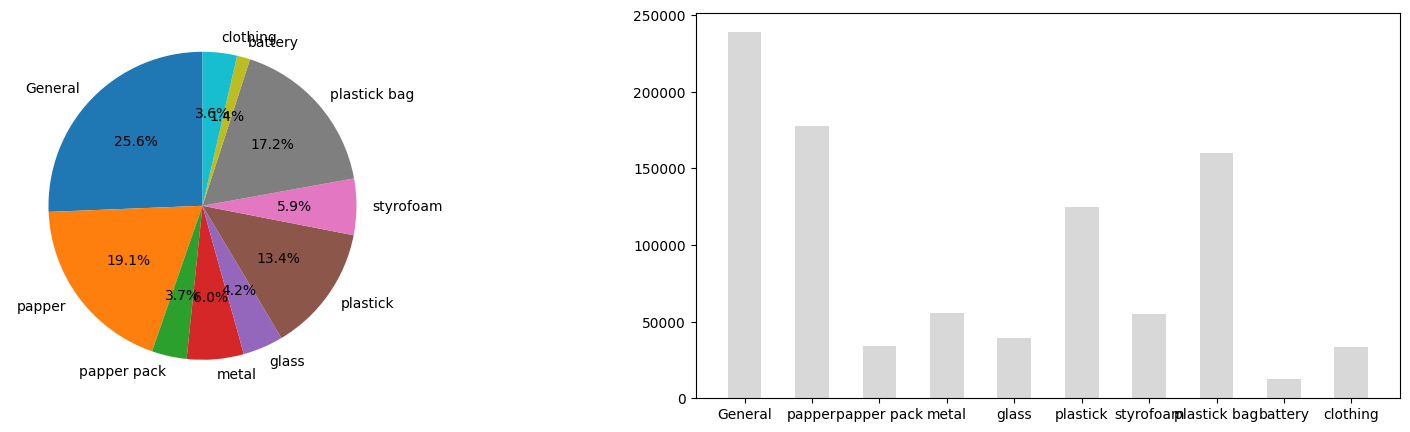

In [162]:
import matplotlib.pyplot as plt

def visual(path:str):
    df = pd.read_csv(path)
    image_ids = df['image_id'].tolist()
    obj = [0, 0, 0, 0, 0 ,0 ,0 ,0 ,0, 0]
    for i, image_id in enumerate(image_ids):
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
                
        for obj_num in predict_list[:, 0].tolist():
            obj[int(obj_num)] += 1
            
            
    labels = ["General", "papper","papper pack", "metal", "glass", "plastick", "styrofoam", "plastick bag", "battery", "clothing"]
    
    fig = plt.figure(figsize=(20, 5)) # 그림 사이즈 지정 (가로 14인치, 세로 5인치)
    ax1 = fig.add_subplot(1, 2, 1) # 서브플롯들을 2 x 1 배열로 배치 그중 첫번째
    ax2 = fig.add_subplot(1, 2, 2) # 서브플롯들을 2 x 1 배열로 배치 그중 두번째
    
    ax1.pie(obj, labels=labels, autopct='%1.1f%%', startangle=90)
    
    ax2.bar(labels, obj, alpha=0.3, color='gray', width=0.5)

    return sum(obj), obj


print(visual("/opt/ml/final_add_nms.csv"))  